<a href="https://colab.research.google.com/github/Gabriel-Esteves-0404/BASECODE/blob/main/BASECOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
%pip install pennylane

In [33]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt


#importações necessárias para o circuito da biblioteca Pennylane

In [34]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

#definição do números de qubits e do modo que esse circuito será executado "default"

In [35]:
from pennylane.templates import StronglyEntanglingLayers

def ansatz(params, x=None): #definição do Ansatz (params = parametro ajustado do qubit; x = dados da entrada)
    StronglyEntanglingLayers(params, wires=range(n_qubits))
#utilização do Ansatz StronglyEntangling da Pennylane

    if x is not None:
        for i in range(n_qubits):
            qml.RX(x[i], wires=i) #Esses dados de entrada (dataset) será aplicada como rotação do eixo X do qubit


In [36]:
@qml.qnode(dev) #Esse decador (@) transforma esse circuit em um circuito quantico do pennylane
#faz simulações, está usando (dev) porque vai incrementar as propriedades do dev no circuit definido abaixo

def circuit(params, x=None): #Aqui é definido o circuit, em que é construido atráves do Ansatz
    ansatz(params, x)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))
#aqui retorna o VEM pelo PauliZ do primeiro qubit

In [37]:
#aqui iremos implementar o (X,Y,x,y) que serão:
# X(todos os valores de entrada do dataset)
# Y(todos os valores de saida esperada // labels ou rótulo)
# x(valor de entrada de cada dado)
# y(valor de saida esperado de cada dado)


def cost(params, X, Y): #definição da função custo
    loss = 0 #a função inicia em 0
    for x, y in zip(X, Y): # Pega um elemento de forma paralela de X e Y (dataset) até
    # o menor deles acabar

        pred0, pred1 = circuit(params, x) # predição do circuito que retorna
        pred = pred0 + pred1
        # o VEM do PauliZ da simualação feita

        loss += (pred - y) ** 2 # adquiri o valor de loss o predição feita, menos o valor
    #de saida esperado (o erro, por assim dizer), elevado ao quadrado para não ter valores
    #negativos e penalizar mais maiores erros (essa é uma forma de calcular a loss)

    return loss / len(X) # aqui vai retorar a média da loss com a quantidade de entrada


In [38]:
!git clone https://github.com/Gabriel-Esteves-0404/BASECODE.git
%cd BASECODE/DATASET
base_path = "./"

Cloning into 'BASECODE'...
remote: Enumerating objects: 920, done.
remote: Counting objects: 100% (920/920), done.
remote: Compressing objects: 100% (912/912), done.
remote: Total 920 (delta 36), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (920/920), 15.01 MiB | 31.56 MiB/s, done.
Resolving deltas: 100% (36/36), done.
/content/BASECODE/DATASET/BASECODE/DATASET/BASECODE/DATASET/BASECODE/DATASET


In [39]:
          #Importação do Dataset (COVID / Normal)

import os
from PIL import Image

size = (64, 64)
# classifica uma dimensão de imagem

def process_image(path):
     img = Image.open(path).convert("L").resize((64, 64))
     return np.array(img) / 255.0
# Nessa parte se define o process_image, em que vai abrir o arquivo inserido na pasta
# pré-definida, a transforma em escala de cinza dimensiona para o valor definido em size
# Normaliza os pixels no intervalo de [0,1]


X = [] #Array dos dados de entradas
y = [] #Array dos labels (rótulos)

# COVID

covid_img_files = sorted(os.listdir(os.path.join(base_path, "COVID_IMAGES")))
covid_mask_files = sorted(os.listdir(os.path.join(base_path, "COVID_MASK")))


for img_file, mask_file in zip(covid_img_files, covid_mask_files):
    img = process_image(os.path.join(base_path, "COVID_IMAGES", img_file))
    mask = process_image(os.path.join(base_path, "COVID_MASK", mask_file))
    img_masked = img * mask
    X.append(img_masked.flatten())
    y.append(1)
# Classificar os dados do COVID juntando a images com os masks (imagens mascaradas)
# dentro da lista X, transforma os dados de entrada de 64x64 px por um vetor de 4096 D
# Defini o COVID como label 1

# NORMAL
normal_img_files = sorted(os.listdir(os.path.join(base_path, "NORMAL_IMAGES")))
normal_mask_files = sorted(os.listdir(os.path.join(base_path, "NORMAL_MASK")))


for img_file, mask_file in zip(normal_img_files, normal_mask_files):
    img = process_image(os.path.join(base_path, "NORMAL_IMAGES", img_file))
    mask = process_image(os.path.join(base_path, "NORMAL_MASK", mask_file))
    img_masked = img * mask
    X.append(img_masked.flatten())
    y.append(0)
# Classificar os dados do Normal juntando a images com os masks (imagens mascaradas)
# dentro da lista X, transforma os dados de entrada de 64x64 px por um vetor de 4096 D
# Defini o Normal como label 0

X = np.array(X)
y = np.array(y)
# Transforma a lista em array do numpy

print("Formato de X:", X.shape) #dados de entrada (10,4096) 10 vetores de 4096D
print("Formato de y:", y.shape) # 10 labels binários
# Checar formato


Formato de X: (400, 4096)
Formato de y: (400,)


In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
# Aqui PCA entende que terá que redimensionar o vetor em 4 componentes

X_reduced = pca.fit_transform(X)
#Analisa os features e transforma os vetores de 4096D em apenas apenas 4 componentes
# na qual se destaca as principais informações do dado


# Verificações
print("X_reduced shape:", X_reduced.shape)


X_reduced shape: (400, 4)


In [ ]:
from sklearn.model_selection import train_test_split

# Divide em 80% treino e 20% validação
X_train, X_val, y_train, y_val = train_test_split(X_reduced, y, test_size=0.2, random_state=42)


In [43]:
n_layers = 3
params = np.random.randn(n_layers, n_qubits, 3, requires_grad=True)

#Nessa parte do código insere-se uma semente aletória para o params inicial, em que tem que
#corresponder ao n_qubits e é habilitado também a função requires_grad

# requires_grad: função do pennylane para o indica o gradinte do da função loss em relação ao parametro
# sendo fundamental para o otimizador ajustar o parametro e minimizar a função loss


In [44]:
opt = qml.optimize.AdamOptimizer(stepsize=0.01)

# stepsize define o quanto o parametro será ajustado em cada interação
# quanto maior o stepsize: será ajustado forte o parametro, pode passar do mínimo e ficar oscilando
# quanto menor: demora mais para se chegar ao mínimo, mas tem mais estabilidade

In [45]:
steps = 30

loss_history = []
for i in range(steps):
    params = opt.step(lambda v: cost(v, X, y.astype(float)), params)

    current_cost = cost(params, X_reduced, y.astype(float))
    loss_history.append(current_cost)


    if i % 1 == 0: #informa que mostrará a loss de 10 em 10
      print(f"Step {i}: Cost = {cost(params, X_reduced,y.astype(float))}")

        #nessa etapa ocorre a representação da evolução da função loss ao decorrer do código
        #com os ajustes do otimizador


Step 0: Cost = 0.6959055575695359
Step 1: Cost = 0.6981763594983468
Step 2: Cost = 0.700669941205969
Step 3: Cost = 0.703245784001053
Step 4: Cost = 0.7057508143632795
Step 5: Cost = 0.7080275564076299
Step 6: Cost = 0.7099266539871398
Step 7: Cost = 0.7113339610762367
Step 8: Cost = 0.7122094184540321
Step 9: Cost = 0.7126036586087396
Step 10: Cost = 0.7126318201576235
Step 11: Cost = 0.7124343129398517
Step 12: Cost = 0.7121527381589986
Step 13: Cost = 0.7119206056083942
Step 14: Cost = 0.7118562194557964
Step 15: Cost = 0.7120468414283928
Step 16: Cost = 0.7125315262569657
Step 17: Cost = 0.7133062112673803
Step 18: Cost = 0.7143485736577994
Step 19: Cost = 0.715637953236888
Step 20: Cost = 0.7171625874220873
Step 21: Cost = 0.7189197617981455
Step 22: Cost = 0.7209135102581951
Step 23: Cost = 0.7231516259000312
Step 24: Cost = 0.7256425456389273
Step 25: Cost = 0.7283923433701787
Step 26: Cost = 0.7314019763778689
Step 27: Cost = 0.7346648944759961
Step 28: Cost = 0.738165105916508

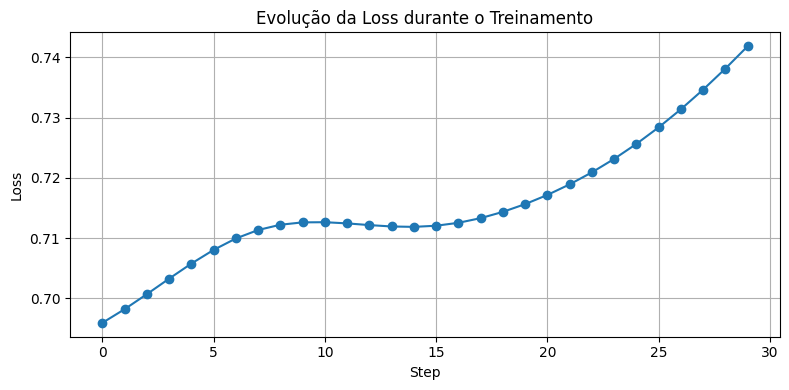

In [46]:
plt.figure(figsize=(8, 4))
plt.plot(loss_history, marker='o')
plt.title("Evolução da Loss durante o Treinamento")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
print(f"Parâmetros finais: {params}")
#parametros finais que utilizam os operadores RY e RX

Parâmetros finais: [[[ 1.6545119   1.64241505 -1.10939647]
  [-0.14643016  0.65586089 -0.37692168]]

 [[-1.35783374 -1.3374723   1.27720564]
  [-1.31650058 -1.012616    0.2651406 ]]

 [[ 0.13603132  0.92907653  0.78899223]
  [-0.05708787 -0.27783908  1.30548132]]]


In [47]:
acertos = 0
for x, y_true in zip(X_reduced, y.astype(float)):
    pred0, pred1 = circuit(params, x)
    pred = pred0 + pred1
    classe = 1 if pred > 0 else 0  # ✅ Corrigido aqui
    if classe == y_true:
        acertos += 1

acuracia = acertos / len(X_reduced)
print(f"Acurácia final: {acuracia * 100:.2f}%")


Acurácia final: 50.00%
